# Задание 2. Скалярное произведение векторов
Необходимо найти скалярное произведение двух векторов. Для этого воспользуемся четырьмя подходами:
- Однопоточный алгоритм
- Распараллеливание по данным в цикле: 
  - С обеспечением синхронизации за счет помещения операции скалярного произведения в критическую секцию
  - С обеспечением синхронизации за счет объявления скалярного произведения атомарной операцией
  - С использованием редукции оператором `+`

## Описание подходов
Все описанные алгоритмы находятся в модуле [`dotProduct`](../dotProduct/dotProduct.c).

### Однопоточная версия
Реализация данного подхода содержится в методе `dotProductSingleThread`. 

```c
int dotProductSingleThread(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int sum = 0;
    for (int i = 0; i < sizeA; i++)
    {
        sum += a[i] * b[i];
    }
    return sum;
}
```

### Синхронизация за счет критической секции
В данном подходе для обеспечения синхронизации потоков скалярное произведение размещено в критической секции.

```c
int dotProductWithCriticalSection(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int sum = 0;
    int i;
#pragma omp parallel for shared(a, b, sizeA) private(i)
    for (i = 0; i < sizeA; i++)
    {
#pragma omp critical
        {
            sum += a[i] * b[i];
        }
    }
    return sum;
}
```

### Синхронизация за счет атомарности
В данном подходе операция сложения помечена как атомарная.
```c
int dotProductWithAtomic(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int sum = 0;
    int i;
#pragma omp parallel for shared(a, b, sizeA) private(i)
    for (i = 0; i < sizeA; i++)
    {
#pragma omp atomic
        sum += a[i] * b[i];
    }
    return sum;
}
```

### Редукция
В данном подходе использована редукция с оператором `+`. 
```c
int dotProductWithReduction(int *a, int *b, int sizeA, int sizeB)
{
    if (sizeA != sizeB)
    {
        exit(-123);
    }
    int sum = 0;
    int i;
#pragma omp parallel for shared(a, b, sizeA) reduction(+ \
                                                       : sum) default(none)

    for (i = 0; i < sizeA; i++)
    {
        sum += a[i] * b[i];
    }
    return sum;
}
```

## Сравнение эффективности алгоритмов
Для сравнения алгоритмов были произведены замеры времени их работы на массивах, состоящих из 100, 10000 и 10000000 элементов. Было проведено 30 экспериментов, их результаты сохранены в файле [output.csv](../build/output.csv). 
Первые 10 строк таблицы представлены ниже.

In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
array_sizes = {100: "small", 10000: "medium", 10000000: "large"}
dataset = dataset.astype({'method': 'category',  'array_size': 'category'})
dataset['array_size'] = dataset['array_size'].replace(array_sizes)
print(dataset.head(10))


             method array_size  elapsed_time
0            single      small        0.0003
1  critical_section      small        0.7139
2            atomic      small        0.0024
3         reduction      small        0.0012
4            single     medium        0.0216
5  critical_section     medium        1.1621
6            atomic     medium        0.1353
7         reduction     medium        0.0051
8            single      large       18.0917
9  critical_section      large     1349.2217


Рассчитаем среднее время работы каждого из описанных подходов при каждом из имеющихся размеров массивов.

In [70]:
means_for_single_thread = dataset[dataset['method'] == 'single'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_critical_section = dataset[dataset['method'] == 'critical_section'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_atomic = dataset[dataset['method'] == 'atomic'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_reduction = dataset[dataset['method'] == 'reduction'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')

In [71]:
def visualize(ylabel, title, data):
    labels = array_sizes.keys()
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x - 3*width/2, data['single'],
                    width, label='Однопоточная версия')
    rects2 = ax.bar(x - width/2, data['critical_section'],
                    width, label='Многопоточная с критической секцией')
    rects3 = ax.bar(x + width/2, data['atomic'], width,
                    label='Многопоточная с атомарной операцией')
    rects4 = ax.bar(x + 3*width/2, data['reduction'],
                    width, label='Многопоточная с редукцией')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Размер массива')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects4, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()


Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого из доступных размеров массивов. 

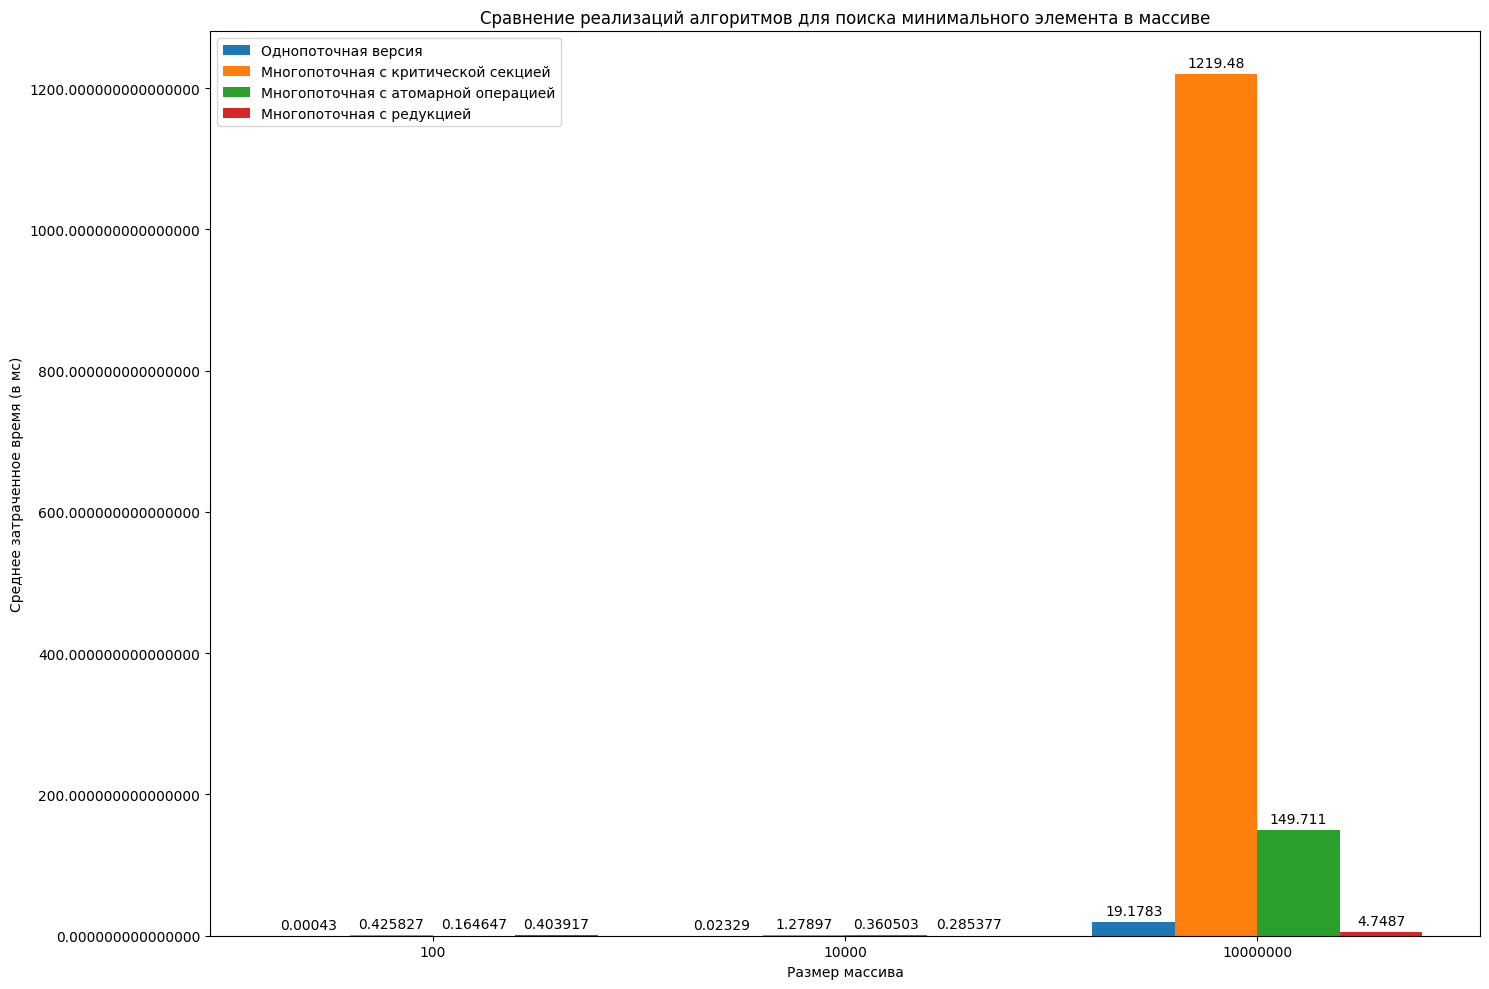

In [72]:
mean_data = dict(zip(dataset['method'].unique(), [
    means_for_single_thread['elapsed_time'], means_for_critical_section['elapsed_time'], means_for_atomic['elapsed_time'], means_for_reduction['elapsed_time']]))
visualize('Среднее затраченное время (в мс)',
          'Сравнение реализаций алгоритмов для поиска минимального элемента в массиве', mean_data)


В данном случае для массивов малого и среднего размеров наиболее эффективной реализацией оказалась однопоточная версия алгоритма. Однако для массивов большого размера редукция оказалась более эффективным подходом. Стоит также заметить, что использование критической секции или атомарных операций в данном случае оказало существенный негативный эффект на скорость работы программы, что особенно заметно на больших массивах. 